In [1]:
import pandas as pd
shots = pd.read_csv("shots_for_model.csv")

In [2]:
wizards_shots = shots[shots["TEAM_NAME"] == "Washington Wizards"]

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Hyperparameters:
{'xgb__subsample': 1.0, 'xgb__n_estimators': 100, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01, 'xgb__colsample_bytree': 0.75}


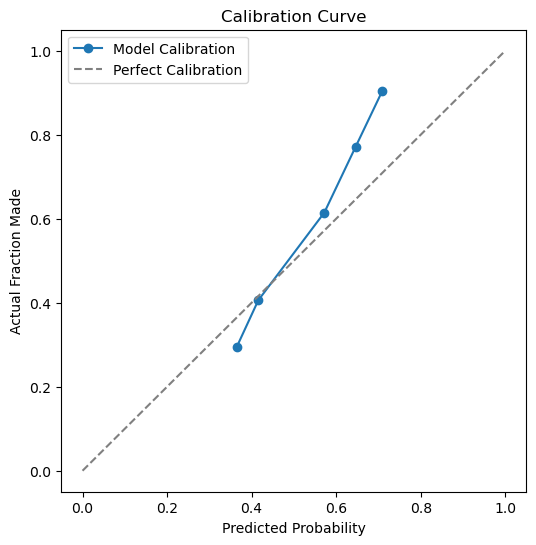


Predicted Overall Shot Success (from model probabilities): 0.466
Actual Overall Shot Success (from data): 0.466

Accuracy: 0.710 | F1 Score: 0.651
Log Loss: 0.6087 (lower is better; measures how well predicted probabilities match actual outcomes)
Brier Score: 0.2088 (lower is better; mean squared error of predicted probabilities)
AUC-ROC: 0.741 (1.0 = perfect ranking of shots, 0.5 = random)
Calibration curve shows whether predicted probabilities are reliable.
Points on diagonal = well-calibrated; above diagonal = underestimates; below = overestimates.


In [25]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer
import numpy as np
from sklearn.metrics import f1_score, make_scorer, log_loss, brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message=".*use_label_encoder.*")



# --------------------------
# DATA & FEATURES
# --------------------------
features = [
    "PLAYER_NAME", 
    "ACTION_TYPE", "SHOT_ZONE"
]

target = "SHOT_MADE_FLAG"

# --------------------------
# PARAM GRID (same as before)
# --------------------------
param_grid = {
    "xgb__n_estimators": [100, 250, 500, 750, 1000],
    "xgb__max_depth": [3, 5, 8, 10, 12],
    "xgb__learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "xgb__subsample": [0.5, 0.75, 1.0],
    "xgb__colsample_bytree": [0.5, 0.75, 1.0]
}

def train_xgb_tuned_full_metrics(wizards_shots, features, target, param_grid):
    X = wizards_shots[features]
    y = wizards_shots[target]

    # Detect categorical variables
    cat_features = [c for c in X.columns if X[c].dtype == "object"]

    preprocessor = ColumnTransformer(
        [("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)],
        remainder="passthrough"
    )

    # Base pipeline
    base_model = Pipeline([
        ("prep", preprocessor),
        ("xgb", XGBClassifier(
            eval_metric="logloss",
            n_jobs=1,
            random_state=42
        ))
    ])

    # Randomized search using F1
    search = RandomizedSearchCV(
        base_model,
        param_distributions=param_grid,
        n_iter=20,
        scoring=make_scorer(f1_score),
        cv=3,
        verbose=1,
        n_jobs=1,
        random_state=42
    )

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Fit the model
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    print("\nBest Hyperparameters:")
    print(search.best_params_)

    # --------------------------
    # MODEL PREDICTIONS
    # --------------------------
    y_proba = best_model.predict_proba(X_test)[:, 1]  # predicted probabilities
    y_pred = (y_proba > 0.5).astype(int)             # thresholded predictions

    # --------------------------
    # STANDARD METRICS
    # --------------------------
    accuracy = best_model.score(X_test, y_test)
    f1 = f1_score(y_test, y_pred)

    # --------------------------
    # PROBABILITY-BASED METRICS
    # --------------------------
    logloss = log_loss(y_test, y_proba)           # Lower is better
    brier = brier_score_loss(y_test, y_proba)     # Lower is better
    auc = roc_auc_score(y_test, y_proba)         # 1.0 = perfect ranking, 0.5 = random

    # --------------------------
    # CALIBRATION CURVE
    # --------------------------
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
    plt.plot([0,1],[0,1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Actual Fraction Made")
    plt.title("Calibration Curve")
    plt.legend()
    plt.show()

    # --------------------------
    # OVERALL PREDICTED vs ACTUAL SUCCESS
    # --------------------------
    predicted_success_rate = np.mean(y_proba)     # average predicted probability
    actual_success_rate = np.mean(y_test)        # observed fraction of made shots

    print(f"\nPredicted Overall Shot Success (from model probabilities): {predicted_success_rate:.3f}")
    print(f"Actual Overall Shot Success (from data): {actual_success_rate:.3f}")

    # --------------------------
    # PRINT RESULTS WITH INTERPRETATION
    # --------------------------
    print(f"\nAccuracy: {accuracy:.3f} | F1 Score: {f1:.3f}")
    print(f"Log Loss: {logloss:.4f} (lower is better; measures how well predicted probabilities match actual outcomes)")
    print(f"Brier Score: {brier:.4f} (lower is better; mean squared error of predicted probabilities)")
    print(f"AUC-ROC: {auc:.3f} (1.0 = perfect ranking of shots, 0.5 = random)")
    print("Calibration curve shows whether predicted probabilities are reliable.\n"
          "Points on diagonal = well-calibrated; above diagonal = underestimates; below = overestimates.")

    return best_model, X_test, y_test, y_proba, accuracy, f1, logloss, brier, auc, predicted_success_rate, actual_success_rate

best_model, X_test, y_test, y_proba, acc, f1, logloss, brier, auc, predicted_success, actual_success = \
    train_xgb_tuned_full_metrics(wizards_shots, features, target, param_grid)

In [33]:
import pandas as pd

# --------------------------
# Create a DataFrame with predictions
# --------------------------
results_df = X_test.copy()
results_df['y_true'] = y_test.values
results_df['y_proba'] = y_proba

# --------------------------
# Group by player and shot zone
# --------------------------
grouped = results_df.groupby(['PLAYER_NAME', 'SHOT_ZONE', 'ACTION_TYPE']).agg(
    predicted_success=('y_proba', 'mean'),   # avg predicted probability
    actual_success=('y_true', 'mean'),       # fraction of shots made
    n_shots=('y_true', 'count')              # number of shots in this group
).reset_index()

# --------------------------
# Optional: sort by player and descending predicted success
# --------------------------
grouped = grouped.sort_values(['predicted_success'], ascending=False)

# --------------------------
# Display results
# --------------------------
grouped


,PLAYER_NAME,SHOT_ZONE,ACTION_TYPE,predicted_success,actual_success,n_shots
31,Bradley Beal,Restricted Area - Center(C),Driving Dunk Shot,0.710118,1.000000,2
321,Otto Porter Jr.,Restricted Area - Center(C),Driving Dunk Shot,0.710118,1.000000,1
254,Markieff Morris,Restricted Area - Center(C),Driving Dunk Shot,0.710118,1.000000,1
283,Nene,Restricted Area - Center(C),Driving Dunk Shot,0.710118,1.000000,3
67,Garrett Temple,Restricted Area - Center(C),Driving Dunk Shot,0.710118,1.000000,1
...,...,...,...,...,...,...
115,John Wall,In The Paint (Non-RA) - Right Side(R),Jump Shot,0.326507,0.000000,1
125,John Wall,Mid-Range - Left Side(L),Jump Shot,0.326507,0.142857,7
118,John Wall,Mid-Range - Center(C),Jump Shot,0.326507,0.214286,14
117,John Wall,Left Corner 3 - Left Side(L),Jump Shot,0.326507,0.000000,3


In [34]:
import pandas as pd

# --------------------------
# STEP 1: Select relevant columns
# --------------------------
# features used in your model
features = ["PLAYER_NAME", "ACTION_TYPE", "SHOT_ZONE"]

# Include SHOT_VALUE so we can respect actual shot values
cols = features + ["SHOT_VALUE"]

# Keep only realistic combinations from your dataset
real_combos = wizards_shots[cols].drop_duplicates().reset_index(drop=True)

# --------------------------
# STEP 2: Predict probabilities
# --------------------------
# The model expects only the features, not SHOT_VALUE
X_features = real_combos[features]

# Predict probability of making the shot
real_combos["pred_probability"] = best_model.predict_proba(X_features)[:, 1]

# --------------------------
# STEP 3: Calculate value-weighted probability
# --------------------------
real_combos["value_weighted_probability"] = real_combos["pred_probability"] * real_combos["SHOT_VALUE"]

# --------------------------
# STEP 4: Optional: sort or group
# --------------------------
# Sort by value-weighted probability (highest first)
real_combos = real_combos.sort_values("value_weighted_probability", ascending=False)

# Optional: aggregate if multiple entries exist per combination
summary = real_combos.groupby(
    ["PLAYER_NAME", "ACTION_TYPE", "SHOT_ZONE", "SHOT_VALUE"]
).agg(
    pred_probability=("pred_probability", "mean"),
    value_weighted_probability=("value_weighted_probability", "mean")
).reset_index()

# --------------------------
# STEP 5: Inspect
# --------------------------
summary.head()


,PLAYER_NAME,ACTION_TYPE,SHOT_ZONE,SHOT_VALUE,pred_probability,value_weighted_probability
0,Bradley Beal,Alley Oop Dunk Shot,Restricted Area - Center(C),2,0.649760,1.299520
1,Bradley Beal,Alley Oop Layup shot,Restricted Area - Center(C),2,0.649760,1.299520
2,Bradley Beal,Cutting Dunk Shot,Restricted Area - Center(C),2,0.675101,1.350202
3,Bradley Beal,Cutting Finger Roll Layup Shot,Restricted Area - Center(C),2,0.649760,1.299520
4,Bradley Beal,Cutting Layup Shot,Restricted Area - Center(C),2,0.674148,1.348297


In [35]:
# Sort by expected goals (value-weighted probability) descending
summary_sorted = summary.sort_values("value_weighted_probability", ascending=False)

# Inspect top rows
summary_sorted.head(20)  # shows top 20 shot combinations by xG


,PLAYER_NAME,ACTION_TYPE,SHOT_ZONE,SHOT_VALUE,pred_probability,value_weighted_probability
729,Ramon Sessions,Pullup Jump shot,Above the Break 3 - Center(C),3,0.614800,1.844400
507,Markieff Morris,Pullup Jump shot,Above the Break 3 - Right Side Center(RC),3,0.614800,1.844400
57,Bradley Beal,Pullup Jump shot,Above the Break 3 - Center(C),3,0.614800,1.844400
59,Bradley Beal,Pullup Jump shot,Above the Break 3 - Right Side Center(RC),3,0.614800,1.844400
127,Garrett Temple,Pullup Jump shot,Above the Break 3 - Center(C),3,0.614800,1.844400
179,Jared Dudley,Pullup Jump shot,Above the Break 3 - Right Side Center(RC),3,0.614800,1.844400
638,Otto Porter Jr.,Pullup Jump shot,Above the Break 3 - Right Side Center(RC),3,0.614800,1.844400
178,Jared Dudley,Pullup Jump shot,Above the Break 3 - Center(C),3,0.614800,1.844400
245,John Wall,Pullup Jump shot,Above the Break 3 - Right Side Center(RC),3,0.614800,1.844400
243,John Wall,Pullup Jump shot,Above the Break 3 - Center(C),3,0.614800,1.844400
